In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io
import json


In [11]:
#%% Paths
# If the dataset has the same structure as on Box, only base_data_dir needs to be changed
base_data_dir = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Hyperspectral'

transect_dir = os.path.join(base_data_dir,'Transects/Transect1-15m-AGL')
trans1_rrs_file = os.path.join(transect_dir,'Reflectance_Bottom','manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-SubtractSpectrum-CorrectFromFlatReference-CropWavelengths.bip.hdr')

annotation_dir = os.path.join(transect_dir,'Annotation')
ann_classes_json = os.path.join(annotation_dir,'label_classes.json')
ann_trans1_im = os.path.join(annotation_dir,'transect1_radiance_rgb_15mAGL.png')

In [130]:
#%% Constants / input parameters
rbg_default = (640, 550, 460)   # Default wavelengths for RGB display
n_samples_per_class = 1000

In [12]:
#%% Import image
im = spectral.io.envi.open(trans1_rrs_file) 

In [13]:
#%% Convert relevant metadata
# Read wavelengths
wl = np.array([float(i) for i in im.metadata['wavelength']])

# Get indices for standard RGB render
rgb_ind = tuple((np.abs(wl - value)).argmin() for value in rbg_default)

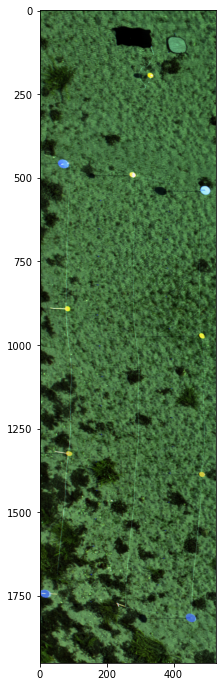

In [14]:
#%% Show image (using spectral version of imshow)
view = spectral.imshow( data=im,bands=rgb_ind, figsize=(6,12))

Text(0, 0.5, '$R_{bottom}$')

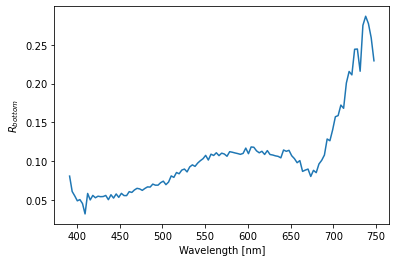

In [15]:
#%% Plot example spectrum
ex_spec = np.squeeze(im[900,400,:]) # Pixel in area with seagrass
plt.plot(wl,ex_spec)
plt.xlabel('Wavelength [nm]')
plt.ylabel('$R_{bottom}$')

In [16]:
#%% Load annotation class info from JSON file
# Read raw text
with open(ann_classes_json, 'r') as myfile:
    data=myfile.read()

# Parse JSON text into list
ann_class_info = json.loads( data)

In [17]:
#%% Build a simple dictionary with class numbers and names
class_dict = {}
for element in ann_class_info:
    class_dict[element['name']] = element['png_index']

In [22]:
#%% Print class dictionary
print('Class : Index \n')
for key,value in class_dict.items():
    print(key + ' : ' + str(value))

Class : Index 

Seagrass-0-25%-density : 1
Seagrass-25-50%-density : 2
Rock(s) : 3
Fucus-vesiculosus : 4
Green algae : 5
Ascophyllum-nodosum : 6
Fucus serratus : 7
Sand : 8
Blue mussels : 9
White-rope : 10
Bamboo-stick : 11
Blue-marker : 12
Red-marker : 13
Yellow-marker : 14
Gray-reference : 15
Black-reference : 16


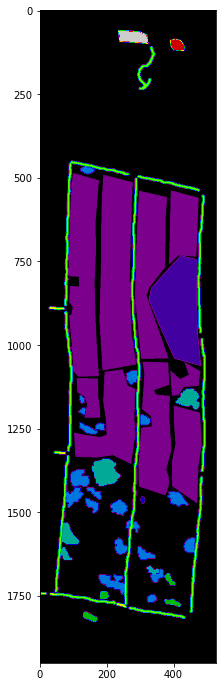

In [23]:
#%% Read and show class PNG file
class_mask = io.imread(ann_trans1_im)
class_mask = np.flip(class_mask,(0,1))    # Annotation image was rotated 180 deg, rotate back

fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(class_mask,cmap='nipy_spectral')

In [75]:
#%% List of classes to use
classes_used = ['Seagrass-0-25%-density',
                'Seagrass-25-50%-density',
                'Fucus-vesiculosus',
                'Ascophyllum-nodosum',
                'Sand']
print(classes_used)

['Seagrass-0-25%-density', 'Seagrass-25-50%-density', 'Fucus-vesiculosus', 'Ascophyllum-nodosum', 'Sand']


In [55]:
#%% Load whole image into memory, cast as "regular" NumPy array
# (Not all types of indexing work with "spectral" image objects)
im_full = np.array(im.load())

In [131]:
#%% Extract training data

# Create random number generator
rng = np.random.default_rng()

# Create list for keeping sample data
class_sample_data = []

for name in classes_used:
    # Create boolean mask for class
    bool_mask = (class_mask == class_dict[name]) 
    
    # Randomly pick sample spectra indices
    ind_y, ind_x = np.where(bool_mask)
    n_samples_total = len(ind_y) 
    rand_samp_ind = rng.choice(n_samples_total, n_samples_per_class, replace=True)

    # Add sample spectra to list
    class_sample_data.append(im_full[ind_y[rand_samp_ind], ind_x[rand_samp_ind],:])


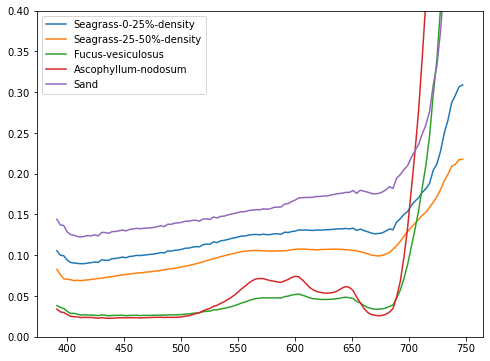

In [132]:
#%% Plot mean spectra 
fig,ax = plt.subplots(figsize=(8,6))
for ind,element in enumerate(class_sample_data):
    plt.plot(wl,element.mean(axis=0),label=classes_used[ind])

plt.ylim((0,0.4))
ax.legend()

In [133]:
#%% Create X and y for model traning
X = np.asarray(class_sample_data)
X = np.reshape(X,(X.shape[0]*X.shape[1], X.shape[2]),order='F')

y = np.zeros((X.shape[0]))
for i in range(len(classes_used)):
    y[i*n_samples_per_class:(i+1)*n_samples_per_class] = i  # Integer class indexing

In [144]:
from sklearn.svm import LinearSVC  # Faster than regular SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(),LinearSVC(dual=False))  # dual = False because n_samp > n_feat
#clf = make_pipeline(StandardScaler(),SVC())  # Takes forever!
clf.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=False))])

In [145]:
#%% Apply model to all pixels in image
X_im = np.reshape(im_full,(im_full.shape[0]*im_full.shape[1],im_full.shape[2]),order='F')
im_classified = np.reshape(clf.predict(X_im),(im_full.shape[0],im_full.shape[1]))

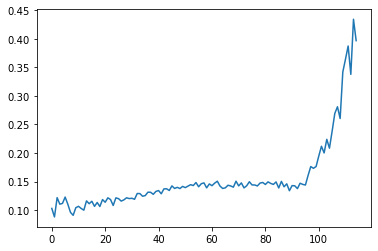

In [140]:
plt.plot(X_im[100000])

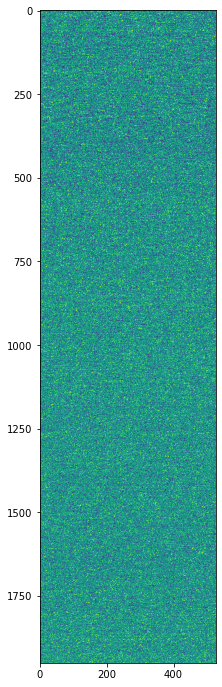

In [146]:
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(im_classified)